<a href="https://colab.research.google.com/github/ysf-s/Hi-Paris-AI-Data-Science-Hackathon-Group-42-/blob/main/Dataset%20discovery%20and%20Feature%20extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PISA Test Dataset Analysis

This notebook analyzes the PISA test dataset to understand its structure and build a predictive model for math scores.

## 1. Load and Explore Data

Load subsets of the training and test data to understand the dataset structure.

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import warnings

warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load first 10000 rows of each dataset
X_train_subset = pd.read_csv('/content/drive/MyDrive/Copy of X_train.csv', nrows=10000)
X_test_subset = pd.read_csv('/content/drive/MyDrive/Copy of X_test.csv', nrows=10000)
y_train_subset = pd.read_csv('/content/drive/MyDrive/Copy of y_train.csv', nrows=10000)

print('X_train shape:', X_train_subset.shape)
print('X_test shape:', X_test_subset.shape)
print('y_train shape:', y_train_subset.shape)

X_train shape: (10000, 307)
X_test shape: (10000, 307)
y_train shape: (10000, 2)


## 2. Dataset Overview

In [5]:
# Display basic information
print('=== X_train Preview ===')
print(X_train_subset.head())
print('\n=== Data Types ===')
print(X_train_subset.info())
print('\n=== Summary Statistics ===')
print(X_train_subset.describe())

=== X_train Preview ===
   Unnamed: 0  Year  CNT  CNTRYID    CNTSCHID    CNTSTUID   CYC  NatCen  \
0      384002  2022  NLD    528.0  52800132.0  52801144.0  08MS   52800   
1     1118072  2018  QAZ     31.0   3100106.0   3100424.0  07MS    3100   
2      845454  2018  FRA    250.0  25000010.0  25005207.0  07MS   25000   
3     1728613  2015  QES    971.0  97100240.0  97127584.0  06MS   72400   
4     1083243  2018  PHL    608.0  60800071.0  60802698.0  07MS   60800   

   STRATUM  SUBNATIO  ...  science_q10_total_timing  science_q11_total_timing  \
0    NLD06   5280000  ...                       NaN                       NaN   
1  QAZ0101    310000  ...                       NaN                       NaN   
2  FRA0101   2500000  ...                   87686.5                  13164.75   
3  ESP1633   7241600  ...                       NaN                       NaN   
4  PHL0011   6080000  ...                       NaN                       NaN   

   science_q12_total_timing  science_q

In [6]:
# Target variable overview
print('=== y_train Preview ===')
print(y_train_subset.head())
print('\n=== MathScore Statistics ===')
print(y_train_subset.describe())

=== y_train Preview ===
   Unnamed: 0   MathScore
0      384002  116.975422
1     1118072   73.387560
2      845454    0.000000
3     1728613    0.000000
4     1083243  113.750718

=== MathScore Statistics ===
         Unnamed: 0     MathScore
count  1.000000e+04  10000.000000
mean   8.750522e+05    102.263856
std    5.070788e+05    124.771153
min    1.460000e+02      0.000000
25%    4.304620e+05      0.000000
50%    8.665785e+05     66.843098
75%    1.314968e+06    153.148944
max    1.757387e+06    764.036681


## 3. Data Preparation

Merge features with target and split by year.

In [7]:
# Merge X_train and y_train
merged_train_df = pd.merge(X_train_subset, y_train_subset, on='Unnamed: 0', how='inner')

# Split by year
df_2015 = merged_train_df[merged_train_df['Year'] == 2015]
df_2018 = merged_train_df[merged_train_df['Year'] == 2018]
df_2022 = merged_train_df[merged_train_df['Year'] == 2022]

print(f'2015: {len(df_2015)} rows')
print(f'2018: {len(df_2018)} rows')
print(f'2022: {len(df_2022)} rows')

2015: 2944 rows
2018: 3506 rows
2022: 3550 rows


4. Missing Value Analysis

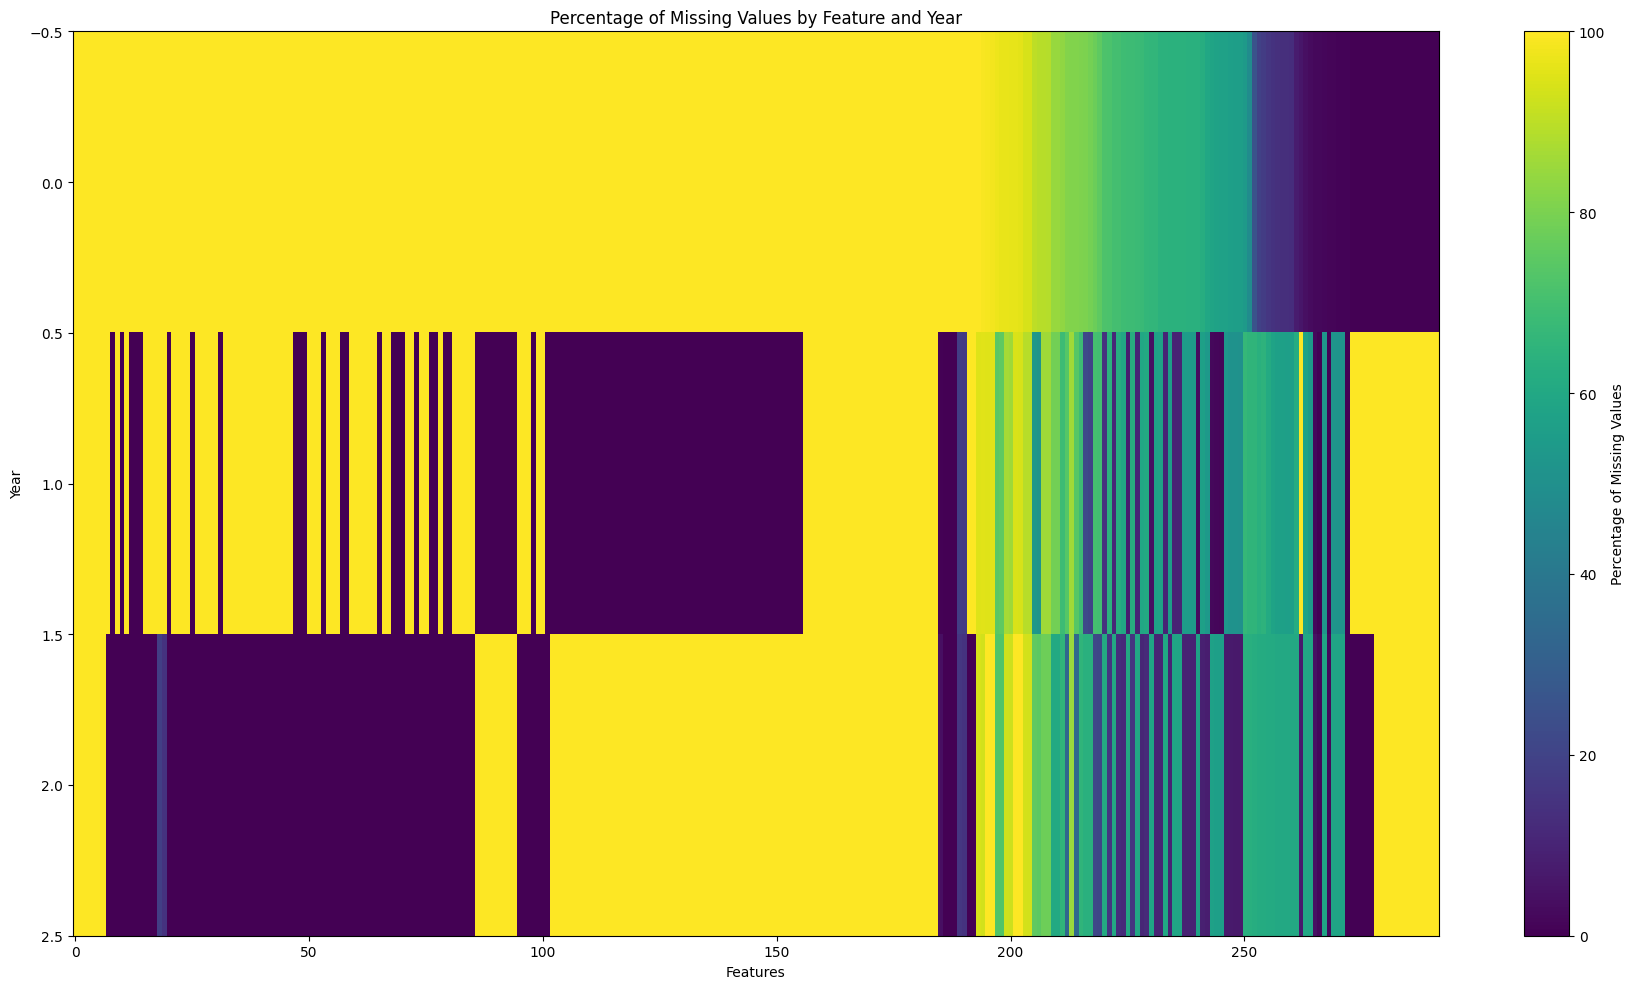

In [8]:
# Analyze missing values by year
missing_2015 = df_2015.isnull().sum() / len(df_2015) * 100
missing_2018 = df_2018.isnull().sum() / len(df_2018) * 100
missing_2022 = df_2022.isnull().sum() / len(df_2022) * 100

missing_data_combined = pd.DataFrame({
    '2015': missing_2015,
    '2018': missing_2018,
    '2022': missing_2022
}).fillna(0)

# Filter columns with any missing values
missing_data_combined = missing_data_combined[(missing_data_combined > 0).any(axis=1)]
missing_data_combined = missing_data_combined.sort_values(by='2015', ascending=False)

# Visualize
plt.figure(figsize=(18, 10))
plt.imshow(missing_data_combined.T, aspect='auto', cmap='viridis')
plt.colorbar(label='Percentage of Missing Values')
plt.title('Percentage of Missing Values by Feature and Year')
plt.xlabel('Features')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

## 5. Feature Engineering

Create proxy features and analyze question attempt patterns.

In [9]:
def get_last_attempted_question(row, subject_prefix):
    """Get the last question number attempted by a student for a subject."""
    question_cols = [col for col in row.index if col.startswith(subject_prefix) and col.endswith('_total_timing')]
    question_cols.sort(key=lambda x: int(x.split('_')[1][1:]))

    last_q = 0
    for i, col in enumerate(question_cols):
        if pd.notna(row[col]):
            last_q = i + 1
        else:
            break
    return last_q

# Create last attempted question features
merged_train_df['last_attempted_science_q'] = merged_train_df.apply(
    lambda row: get_last_attempted_question(row, 'science_q'), axis=1
)
merged_train_df['last_attempted_math_q'] = merged_train_df.apply(
    lambda row: get_last_attempted_question(row, 'math_q'), axis=1
)
merged_train_df['last_attempted_reading_q'] = merged_train_df.apply(
    lambda row: get_last_attempted_question(row, 'reading_q'), axis=1
)

print(merged_train_df[['last_attempted_science_q', 'last_attempted_math_q', 'last_attempted_reading_q']].head())

   last_attempted_science_q  last_attempted_math_q  last_attempted_reading_q
0                         9                     10                         0
1                         0                     10                         8
2                        12                      0                         8
3                         9                      0                         9
4                         0                      9                         9


## 6. Zero Math Score Analysis

In [10]:
# Analyze students with zero math scores
zero_math_score_students = merged_train_df[merged_train_df['MathScore'] == 0]

students_zero_score_no_attempt = zero_math_score_students[zero_math_score_students['last_attempted_math_q'] == 0]
students_zero_score_with_attempt = zero_math_score_students[zero_math_score_students['last_attempted_math_q'] > 0]

print(f"Total students with MathScore == 0: {len(zero_math_score_students)}")
print(f"  - No math questions attempted: {len(students_zero_score_no_attempt)}")
print(f"  - Attempted math questions but scored 0: {len(students_zero_score_with_attempt)}")

Total students with MathScore == 0: 3733
  - No math questions attempted: 3673
  - Attempted math questions but scored 0: 60


## 7. Correlation Analysis

Identify features most correlated with math scores.

In [11]:
from sklearn.feature_selection import mutual_info_regression

# Prepare features and target
y = merged_train_df['MathScore']
X = merged_train_df.drop('MathScore', axis=1).copy()

# Remove non-predictive columns
columns_to_drop = ['Unnamed: 0', 'last_attempted_math_q'] + \
                  [col for col in X.columns if col.startswith('math_q') and 'average_score' in col]
X = X.drop(columns=columns_to_drop, errors='ignore')

# One-hot encode categorical variables
categorical_cols = X.select_dtypes(include='object').columns.tolist()
X = pd.get_dummies(X, columns=categorical_cols, drop_first=False)

# Impute missing values
numerical_cols_with_nan = X.select_dtypes(include=['float64', 'int64']).columns[
    X.select_dtypes(include=['float64', 'int64']).isnull().any()
].tolist()

for col in numerical_cols_with_nan:
    if X[col].isnull().all():
        X[col] = X[col].fillna(0)
    else:
        X[col] = X[col].fillna(X[col].mean())

# Calculate correlations
pearson_correlations = X.corrwith(y, method='pearson')
spearman_correlations = X.corrwith(y, method='spearman')
mutual_info_scores = pd.Series(mutual_info_regression(X, y), index=X.columns)

# Consolidate results.

correlation_df = pd.DataFrame({
    'Pearson': pearson_correlations,
    'Spearman': spearman_correlations,
    'Mutual_Information': mutual_info_scores
})
correlation_df['Pearson_Abs'] = correlation_df['Pearson'].abs()
correlation_df = correlation_df.sort_values(by='Pearson_Abs', ascending=False)

print('Top 20 Features by Correlation:')
print(correlation_df.head(20))

Top 20 Features by Correlation:
                           Pearson  Spearman  Mutual_Information  Pearson_Abs
last_attempted_science_q -0.228045 -0.313385            0.263775     0.228045
ST255                     0.148557  0.129545            0.576988     0.148557
math_q1_total_timing      0.132490 -0.034584            0.541810     0.132490
reading_q6_average_score  0.128049  0.060957            0.189417     0.128049
math_q7_total_timing      0.123524 -0.043368            0.496668     0.123524
reading_q3_average_score  0.121107  0.076540            0.218247     0.121107
reading_q5_average_score  0.120205  0.083771            0.201275     0.120205
science_q6_average_score  0.118359  0.121301            0.277814     0.118359
reading_q7_average_score  0.115035  0.068276            0.129349     0.115035
reading_q4_average_score  0.113735  0.075733            0.212686     0.113735
OECD                      0.110648  0.080235            0.044575     0.110648
science_q5_average_score  0.1102